In [1]:
from scipy.spatial.distance import cdist
def rbf_kernel(x1, x2, varSigma, lengthscale):
    if x2 is None:
        d = cdist(x1, x1)
    else:
        d = cdist(x1, x2)
    K = varSigma*np.exp(-np.power(d, 2)/lengthscale)
    return K

In [2]:
import numpy as np
#theta[0]==varSigma,theta[1]==lengthscale,theta[2]==noise
def surrogate_belief(x,f,xstar,theta):
    k_starX = rbf_kernel(xstar,x,theta[0],theta[1])
    k_xx = rbf_kernel(x, None,theta[0],theta[1])
    k_starstar = rbf_kernel(xstar,None,theta[0],theta[1])
    mu = k_starX.dot(np.linalg.inv(k_xx+theta[2]*np.eye(k_xx.shape[0]))).dot(f)
    var = k_starstar - (k_starX).dot(np.linalg.inv(k_xx+theta[2]*np.eye(k_xx.shape[0]))).dot(k_starX.T)
    return mu, var

In [3]:
from scipy.stats import norm
import random
def expected_improvement(f_max, mu, varSigma, x):
    X_num=np.arange(x.shape[0])
    alpha=(f_max-mu[X_num].ravel())*norm.cdf(f_max,mu[X_num].ravel(),varSigma[X_num,X_num])+varSigma[X_num,X_num]*norm.pdf(f_max,mu[X_num].ravel(),varSigma[X_num,X_num])
    return alpha

In [4]:
def f(x, A=1, B=0, C=0):
    return A*(6*x-2)**2*np.sin(12*x-4) + B*(x-0.5) + C

In [5]:
#####Experiments I#####
N=500    #number of domain X
iter=10     #number of iteration
theta=[1,0.001,0.0000003]     #parameters of rbf_kernel
X=np.linspace(0,1,N)     #initial X    
index = np.random.permutation(N)
x_star=X[index[:5]]      #sample point
f_start=f(x_star)
ind=np.argmin(f_start)
f_max=f(x_star[ind])
for i in range(iter):
    mu,varSigma=surrogate_belief(x_star.reshape(-1,1),f(x_star.reshape(-1,1)),X.reshape(-1,1),theta)
    alphaX=expected_improvement(f_max, mu, varSigma, X)
    ind=np.argmax(alphaX)
    x_star=np.append(x_star,X[ind])
    if f(x_star[-1])<f_max:
        f_max=f(x_star[-1])

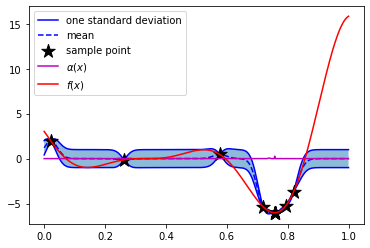

In [6]:
#####Experiments I plot#####
import matplotlib.pyplot as plt
mu,varSigma=surrogate_belief(x_star.reshape(-1,1),f(x_star.reshape(-1,1)),X.reshape(-1,1),theta)
fmean=mu.ravel()
mu_shape=np.arange(mu.shape[0])
std=np.sqrt(varSigma[mu_shape,mu_shape])
fmax=fmean+std
fmin=fmean-std
y_real=f(X)
alphaX=expected_improvement(f_max, mu, varSigma, X)
plt.fill_between(X,fmax,fmin,alpha=0.5);
plt.plot(X,fmin,c='b',linestyle='-',label='one standard deviation');
plt.plot(X,fmax,c='b',linestyle='-');
plt.plot(X,fmean,c='b',linestyle='--',label='mean');
plt.scatter(x_star, f(x_star), 200, 'k', '*', zorder=2,label='sample point');
plt.plot(X,alphaX,c='m',label='$\\alpha(x)$')
plt.plot(X,y_real,c='r',label='$f(x)$');
plt.legend(loc='upper left');

In [ ]:
#####Experiments II#####
def f2(x, beta=0.2, alpha1=1.0, alpha2=1.0):
    return np.sin(3.0*x) - alpha1*x + alpha2*x**2 + beta*np.random.randn(x.shape[0])

In [ ]:
import GPy
kernel = GPy.kern.RBF(input_dim=1, variance=1.0, lengthscale=4.0)

In [ ]:
domain = [{'name': 'var_1', 'type': 'continuous', 'domain': (-3,3)}]

In [ ]:
from GPyOpt.methods import BayesianOptimization
opt = BayesianOptimization(f=f2, domain=domain,model_type='GP',initial_design_numdata = 1,kernel=kernel, acquisition_type='EI')
opt.run_optimization(max_iter=6)
opt.plot_acquisition()

In [ ]:
def f(x, alpha=1.0, beta=0.5, gamma=0.2):
    return alpha*np.sin(2*np.pi*x/10) + ((beta*np.sin((2*np.pi*x/0.5))) +
            (gamma*x) +(0.1*np.random.randn(x.shape[0])))
kernel_rbf = GPy.kern.RBF(input_dim=1, variance=1.0, lengthscale=4.0)
kernel_cmpnd = ((GPy.kern.RBF(input_dim=1, variance=1.0, lengthscale=4.0)) +
                (GPy.kern.StdPeriodic(input_dim=1, variance=1.0, period=10.0)) +
                (GPy.kern.StdPeriodic(input_dim=1, variance=1.0, period=0.5)) +
                (GPy.kern.Linear(input_dim = 1)) +
                (GPy.kern.White(input_dim=1, variance=0.1)))
domain = [{'name': 'var_1', 'type': 'continuous', 'domain': (0,10)}]
opt = BayesianOptimization(f=f, domain=domain,model_type='GP',
                            kernel=kernel_cmpnd,
                            acquisition_type='EI',
                            initial_design_numdata=5)
opt.run_optimization(max_iter=10)
opt.plot_acquisition()